# Assignment
Hi Rafael,

Hope you are well. The next step in our process at Innatera is a coding assignment with spiking neural networks. The task below is to be completed and returned to us by 13th May. 

Task
Implement a looped Synfire chain with 5 layers, each layer with 5 neurons. Layers are fully connected in a feed-forward fashion. The last layer is fully-connected back to the first layer completing the loop. Input is provided in the form of a single spike broadcasted to all neurons in the first layer with sufficient synaptic strength to make all 5 neurons spike once.
The implementation is to be done in Lava and in any other open-source simulator of your choice (this can be your own simulator as well). The language choice is up to you.

a) Plot the spike raster for at least 3 oscillations.
b) Compare differences, if any, between the two simulators.
c) Tune parameters of the network such that the 100th spike occurs at 100ms from the input spike.

Usage of open-source repositories is allowed as long as the functions used can be explained. Please send your files as an archive. A README file to allow us to run it should also be present.
Please do not hesitate to ask any questions for clarification if any. Also feel free to make any assumptions that you can reasonably justify. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
%matplotlib inline

INFO       Cache size for target 'cython': 1338914223 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\rjpbe\.cython\brian_extensions' directory. [brian2]


First I will create the LIF model. I assume that the network must be stable. Since Brian2 has many more options than Lava, e.g. you can define a non-CuBa synapses, this part of the assignment will be much simpler. The objective is to show that I can solve the problem in different ways given the directives.

In [2]:
# The network must have at least 3 oscillations and the 100th spike must be at the 100th ms
duration = 101*ms

#I set the resting potential at 0 since there is no necessity of replicating bio-inspired behaviours
Vr = 0 * mV

#I set the threshold at 20 mv
Vt = 20 * mV

#The decay will be 10 ms, although the network will does not have subthreshold dynamics so this parameter doesnt make a difference
tau = 10*ms

#5 neurons per layer
layer_width=5

#5 layers
n_layers=5

#The value of the weights will be 5. Note that this number has been chosen so that the different pools of neurons 
#will only elicit an action potential if the 5 neurons spike at the same spike-time.
weight = 5*mV

#Equation defining the LIF
eqs = '''dv/dt = ((Vr - v) + I)/tau : volt
         I : volt'''

#Creation of the pools of neurons.
group = NeuronGroup(layer_width*n_layers, eqs,
                    threshold='v > Vt',
                    reset='v = Vr', method="euler")


In [3]:
#Creation of a spike generator to send the first spike to the first layer. It has been set to spike at the 2nd ms to tune
#the network so that the 100th spike lies at the 100th ms.
spkgen=SpikeGeneratorGroup(layer_width,np.arange(layer_width),2*np.ones(layer_width)*1*ms)

#Creation of the indexes that define each of the layers
syn=[[(m)*layer_width+k for k in range(layer_width)] for m in range(n_layers)]

#Synapse from the spike generator to the first layer. Note that it is not a CuBa synapse, meaning that the computations
#in the other part of the assignment are not needed.
syn_spkgen = Synapses(spkgen, group[:layer_width], on_pre='v+=weight')
syn_spkgen.connect()

#synapse from each of the layers to the next.
syn_group = Synapses(group, group, on_pre='v+=weight')
for k in range(layer_width-1):
    syn_group.connect( i = syn[k], j=syn[(k+1)%layer_width],n=layer_width)

#Synaptic delay between layers to adjust dynamics
syn_group.delay=6*ms

#I created a different synapse from the last layer to the first so that it is instant.
syn_rec = Synapses(group, group, on_pre='v+=weight')
syn_rec.connect( i = syn[4], j=syn[(0)],n=layer_width)
syn_rec.delay = 0*ms

#Monitors to record the spikes and the voltage of the layers
monV= StateMonitor(group,"v",record=True)
monU= StateMonitor(group,"I",record=True)
mon_spkgen = SpikeMonitor(spkgen)
mon_group = SpikeMonitor(group)


In [4]:
#Run simulation
run(duration)

Text(0.5, 1.0, 'Raster plot')

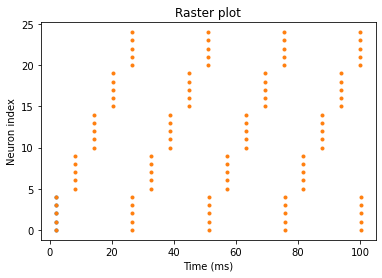

In [5]:
#Raster plot showing all the layers.
plot(mon_spkgen.t/ms, mon_spkgen.i, '.')
plot(mon_group.t/ms, mon_group.i, '.')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("Raster plot")

Note that the layers are evenly spaced. The layers are connected as specified, in a feed-forward fully connected fashion, with a recurrent connection from the first to the last.

Text(0.5, 1.0, 'Voltage of a neuron of in the last layer')

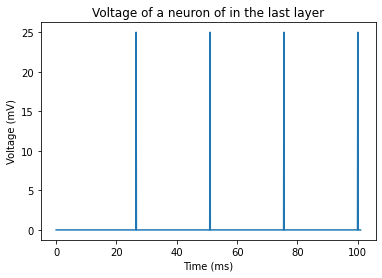

In [6]:
plot(monV.t/ms,monV.v[24]/mV)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Voltage of a neuron of in the last layer")

The spikes from the last layer (in which the 100th spike is) lie at the 100th ms.

## Comparison between the CuBa LIF model and this one
The main difference between the two models is the way in which the synapses propagate the action potential. Note that this model is way simpler, since its subthrshold dynamics are not employed. However, if it was desired a change in the difference between spike-times from one oscillation to the next one, i.e. an unstable synfire chain, this model would need some input current. The CuBA LIF model in Lava would just need to modify its decays or its initial delays to accomplish it.